# Introduction
This notebook was written by Rafael Oliveira on 2024-07-02.

In this notebook, you will find examples of various fundamental data processing procedures including:

- Web Scraping: Demonstrates how to gather data concerning interest rate futures from the web using automated techniques.
- Data Cleaning: Shows the process of cleaning the scraped data to ensure accuracy and consistency.
- Data Transformation: Illustrates how to calculate key financial metrics such as the time to maturity and interest rates from the cleaned data.
- Visualization: Provides examples of how to visualize the processed data to uncover insights and trends.

This notebook serves as a practical guide and a starting point for more complex financial data analysis projects.

## User defined parameters

In [ ]:
# Install packages from requirements.txt
!pip install -r requirements.txt

In [4]:
# Set the market of interest.
# - 'DI1' represents Brazilian nominal rates futures.
# - 'DAP' represents Brazilian real rates futures.
MARKET = 'DI1'

In [5]:
# Set the reference date of interest.
# This date must be a past trading day in the Brazilian market.
# Format: 'YYYY-MM-DD'
REF_DATE = '2024-07-01'

## Web scraping

In [6]:
from datetime import datetime


# Function to build the URL for web scraping
def generate_url_for_scraping(market: str, date: str) -> str:
    formatted_date = datetime.strptime(date, '%Y-%m-%d').strftime('%d/%m/%Y')
    return f'https://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data={formatted_date}&Mercadoria={market}'

# Generate URL using the specified market and reference date
url = generate_url_for_scraping(MARKET, REF_DATE)
print(url)

https://www2.bmf.com.br/pages/portal/bmfbovespa/boletim1/SistemaPregao1.asp?pagetype=pop&caminho=Resumo%20Estat%EDstico%20-%20Sistema%20Preg%E3o&Data=01/07/2024&Mercadoria=DI1


In [7]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from io import StringIO

# Function to scrape data from the BMF website
def scrape_data_from_bmf_website(url: str) -> pd.DataFrame:
    # Set up headless Chrome options
    options = webdriver.ChromeOptions()
    options.add_argument("--headless=new")
    service = Service(ChromeDriverManager().install())
    
    # Use a context manager to ensure the driver is closed properly
    with webdriver.Chrome(service=service, options=options) as driver:
        driver.get(url)
        
        # Create a dictionary to define relevant columns and their new names.
        COLUMNS_RENAME = {
            'VENCTO': 'expiration_code',  # Column for expiration code
            'AJUSTE': 'settlement',       # Column for settlement values
        }

        # Check if the page indicates no data is available
        if 'Não há dados para a data consultada.' in driver.page_source:
            return pd.DataFrame(columns=list(COLUMNS_RENAME.values()))
        
        try:
            # Scrape data from the specified elements
            element_first_table = driver.find_element(By.ID, 'MercadoFut0')
            first_df = pd.read_html(StringIO(element_first_table.get_attribute("innerHTML")), header=0, decimal=',', thousands='.')[0]

            element_second_table = driver.find_element(By.ID, 'MercadoFut2')
            second_df = pd.read_html(StringIO(element_second_table.get_attribute("innerHTML")), header=0, decimal=',', thousands='.')[0]
        
            # Concatenate the dataframes and rename columns
            df = pd.concat([first_df, second_df], axis=1)
            return df[COLUMNS_RENAME.keys()].rename(columns=COLUMNS_RENAME)
        except Exception as e:
            print(f"Error processing URL {url}: {e}")
            return pd.DataFrame(columns=list(COLUMNS_RENAME.values()))

# Scrape data from the generated URL
df = scrape_data_from_bmf_website(url)
df.head()

,expiration_code,settlement
0,N24,100000.00
1,Q24,99098.67
2,U24,98235.71
3,V24,97409.66
4,X24,96500.94


## Expiration Dates

The retrieved data only contains expiration codes, not explicit expiration dates.

- **Expiration Codes**: These codes are sufficient to identify the month and year of expiration. Each code consists of a letter representing the month and a two-digit number representing the year.
  
- **Month and Year**: The first character of the expiration code is a letter (e.g., 'F', 'G', 'H'), which corresponds to a specific month. The subsequent two digits represent the year.

- **Day of Expiration**: The specific day of expiration depends on the market. For example, the expiration day is the first of the month for the 'DI1' market and the fifteenth of the month for the 'DAP' market.

By using these codes along with predefined mappings for months and markets, we can accurately calculate the expiration dates for each contract.

In [8]:
import pandas as pd
from datetime import datetime

# Define expiration month codes and corresponding months
EXPIRATION_MONTH = {
    'F': 1,  # January
    'G': 2,  # February
    'H': 3,  # March
    'J': 4,  # April
    'K': 5,  # May
    'M': 6,  # June
    'N': 7,  # July
    'Q': 8,  # August
    'U': 9,  # September
    'V': 10, # October
    'X': 11, # November
    'Z': 12, # December
}

# Define expiration days for different markets
EXPIRATION_DAY = {
    'DI1': 1,   # First day of the month for DI1 contracts
    'DAP': 15,  # Fifteenth day of the month for DAP contracts
}

# Function to calculate the unadjusted expiration date for each contract
def calculate_expiration_date(row, market):
    month_code = row.expiration_code[0]
    month = EXPIRATION_MONTH[month_code]
    year = int(row.expiration_code[1:]) + 2000
    day = EXPIRATION_DAY[market]
    expiration_date = datetime(year, month, day)
    return expiration_date

# Apply the function to calculate expiration dates and add a new column to the DataFrame
df['expiration_date'] = df.apply(calculate_expiration_date, axis=1, args=(MARKET,))
df.head()

,expiration_code,settlement,expiration_date
0,N24,100000.00,2024-07-01
1,Q24,99098.67,2024-08-01
2,U24,98235.71,2024-09-01
3,V24,97409.66,2024-10-01
4,X24,96500.94,2024-11-01


## Adjusted Expiration Dates

The expiration dates calculated in the previous step may not fall on a trading day. In such cases, the expiration date is adjusted to the following business day.

- **Non-Trading Days**: Expiration dates can sometimes fall on weekends or holidays, which are non-trading days.

- **Adjustment Rule**: When an expiration date falls on a non-trading day, it is moved to the next business day to ensure it aligns with market trading days.

- **Holidays Calendar**: The best available holidays calendar is published by ANBIMA. This calendar is utilized to adjust the expiration dates appropriately.

By referencing the ANBIMA holidays calendar, we ensure that all expiration dates are accurately adjusted to fall on valid trading days.

In [9]:
import xlrd
from datetime import date
from urllib.request import urlretrieve

# Define URL for ANBIMA holidays calendar
anbima_url = 'http://www.anbima.com.br/feriados/arqs/feriados_nacionais.xls'
path = 'holidays_anbima.xls'

# Download the holidays file from ANBIMA
response = urlretrieve(anbima_url, filename=path)

# Open the workbook and select the first sheet
wb = xlrd.open_workbook(path)
ws = wb.sheet_by_index(0)

# Initialize a list to hold holiday dates
holidays = []

# Iterate through the rows to extract holiday dates
i = 1
while ws.cell_type(i, 0) == 3:  # 3 indicates an Excel date cell
    y, m, d, _, _, _ = xlrd.xldate_as_tuple(ws.cell_value(i, 0), wb.datemode)
    holidays.append(date(y, m, d))
    i += 1

# Print the first and last 5 holidays to verify
print(holidays[:5])
print(holidays[-5:])

[datetime.date(2001, 1, 1), datetime.date(2001, 2, 26), datetime.date(2001, 2, 27), datetime.date(2001, 4, 13), datetime.date(2001, 4, 21)]
[datetime.date(2099, 10, 12), datetime.date(2099, 11, 2), datetime.date(2099, 11, 15), datetime.date(2099, 11, 20), datetime.date(2099, 12, 25)]


In [10]:
import pandas as pd
from datetime import timedelta

# Function to adjust dates to the next business day
def adjust_to_business_day(date, holidays):
    """
    Adjusts the given date to the next business day if it falls on a weekend or holiday.

    Parameters:
    date (datetime.date): The original date to adjust.
    holidays (list of datetime.date): A list of holiday dates.

    Returns:
    datetime.date: The adjusted business day date.
    """
    while date.weekday() >= 5 or date in holidays:  # 5 is Saturday, 6 is Sunday
        date += timedelta(days=1)
    return date

# Apply the function to the expiration dates series to get adjusted expiration dates
df['adj_expiration_date'] = df['expiration_date'].apply(lambda x: adjust_to_business_day(x, holidays))

# Display the first few rows of the DataFrame to verify the changes
df.head()

,expiration_code,settlement,expiration_date,adj_expiration_date
0,N24,100000.00,2024-07-01,2024-07-01
1,Q24,99098.67,2024-08-01,2024-08-01
2,U24,98235.71,2024-09-01,2024-09-02
3,V24,97409.66,2024-10-01,2024-10-01
4,X24,96500.94,2024-11-01,2024-11-01


## Time to Maturity

Using the reference date (defined by the user at the beginning of this notebook) and the adjusted expiration dates, we can calculate the number of business days until maturity. 

### Steps:
1. **Calculate Business Days Until Maturity**: Determine the number of business days between the reference date and each adjusted expiration date.
2. **Convert to Years**: Use the Brazilian convention of 252 business days in a year to convert the business days to years.

These calculations are essential for accurate financial analysis and modeling, providing a clear timeline for the maturity of each contract.

In [11]:
import pandas as pd
from pandas.tseries.offsets import CustomBusinessDay

# Define the reference date
ref_date = pd.to_datetime(REF_DATE)

# Define the custom business day convention with holidays
custom_bday = CustomBusinessDay(holidays=holidays)

# Function to calculate years to maturity between two dates
def calculate_years_to_maturity(start_date, end_date):
    business_days_to_maturity = len(pd.date_range(start=start_date, end=end_date, freq=custom_bday)) - 1  # Subtract 1 because the start date is inclusive
    return business_days_to_maturity / 252

# Calculate business days to maturity and years to maturity
df['years_to_maturity'] = df['adj_expiration_date'].apply(lambda x: calculate_years_to_maturity(ref_date, x))

# Display the first few rows of the DataFrame to verify the changes
df.head()

,expiration_code,settlement,expiration_date,adj_expiration_date,years_to_maturity
0,N24,100000.00,2024-07-01,2024-07-01,0.000000
1,Q24,99098.67,2024-08-01,2024-08-01,0.091270
2,U24,98235.71,2024-09-01,2024-09-02,0.178571
3,V24,97409.66,2024-10-01,2024-10-01,0.261905
4,X24,96500.94,2024-11-01,2024-11-01,0.353175


## Rates

The scraped data contains various rate information, such as open, high, low, close, and average rates. However, for financial analysis using daily historical prices, the most relevant rate is the one associated with the settlement prices. Unfortunately, this rate is not directly available in the scraped data. 

It is possible to calculate the settlement rate using the settlement price and the time to maturity.

In [12]:
# Calculate the annualized rates implied by the settlement prices
df['rate'] = ((100_000 / df['settlement']) ** (1 / df['years_to_maturity']) - 1) * 100

# Display the first few rows of the DataFrame to verify the changes
df.head()

,expiration_code,settlement,expiration_date,adj_expiration_date,years_to_maturity,rate
0,N24,100000.00,2024-07-01,2024-07-01,0.000000,0.000000
1,Q24,99098.67,2024-08-01,2024-08-01,0.091270,10.428952
2,U24,98235.71,2024-09-01,2024-09-02,0.178571,10.481974
3,V24,97409.66,2024-10-01,2024-10-01,0.261905,10.540018
4,X24,96500.94,2024-11-01,2024-11-01,0.353175,10.611002


## Visualization

In [13]:
# Define the columns we want to keep
WANTED_COLUMNS = ['years_to_maturity', 'rate']

# Filter the DataFrame to include only relevant rows and columns
# Eliminate contracts that are expiring on the reference date (years_to_maturity = 0)
df_filtered = df[df['years_to_maturity'] > 0][WANTED_COLUMNS].copy()

# Set 'years_to_maturity' as the index for easier plotting and analysis
df_filtered.set_index('years_to_maturity', inplace=True)

# Display the first few rows of the filtered DataFrame to verify the changes
df_filtered.head()

,rate
years_to_maturity,
0.091270,10.428952
0.178571,10.481974
0.261905,10.540018
0.353175,10.611002
0.428571,10.710012


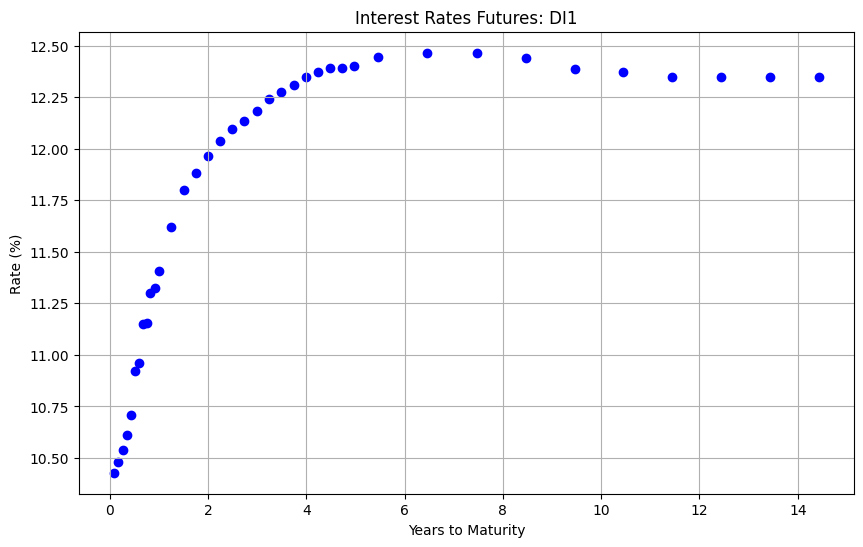

In [14]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Plot of rates versus years
# In later projects, this will be the starting point for the construction of interest rate curves

# Plot the chart
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered.index, df_filtered['rate'], marker='o', color='b')  # Scatter plot with markers
plt.xlabel('Years to Maturity')
plt.ylabel('Rate (%)')
plt.title(f'Interest Rates Futures: {MARKET}')
plt.grid(True)
plt.show()

In [15]:
# Export the filtered DataFrame to a CSV file
df_filtered.to_csv(f'rates_{MARKET}.csv', index=True)